# Ask meaningful questions and answer using collected data

## Import necessary packages

In [561]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Read raw data from csv file

In [562]:
df = pd.DataFrame()
df = pd.read_csv('players_transformed.csv')

# drop unecessary column
df = df.drop(df.columns[0], axis=1)

# test output
display(df.head())

# size of the data
print("Size of data: ", df.shape)

,name,age,nationality,club,height,weight,foot,total_matches,total_goals,total_assists,total_yellow,total_red,pass_completion_rate,dribble_success_rate,tackles,interception,market_value,titles,injuries,general_position
0,Ivan Balliu,32,Albania,Rayo Vallecano,172,63,Right,421,3,14,91,2,76.73,66.67,10,6,2.0,2,19,Defender
1,Marash Kumbulla,24,Albania,RCD Espanyol,191,78,Right,132,6,14,32,2,86.24,33.33,12,11,4.5,1,2,Defender
2,Abderrahman Rebbach,26,Algeria,Deportivo Alavés,176,75,Right,154,34,4,32,1,72.09,27.27,0,0,0.8,0,0,Forward
3,Farid El Melali,27,Algeria,Angers SCO,168,65,Right,157,19,8,11,0,82.00,54.29,10,3,1.5,1,12,Forward
4,Haris Belkebla,30,Algeria,Angers SCO,177,68,Right,323,9,2,57,3,87.00,25.00,9,5,1.5,0,6,Midfielder


Size of data:  (1057, 20)


## Question 1
> Can we identify young players (e.g., under 23) who have high efficiency and are undervalued in the market compared to their peers?

### Purpose
To identify promising young players who deliver exceptional performance relative to their market value, making them attractive targets for clubs seeking high-value talent on a budget.

### Relevant attributes
- `age`
- `market_value`
- `total_goals`
- `total_assists`
- `dribble_success_rate`

### 1. Filter Players Under 23 and Define Efficiency Metrics

Efficiency is calculated by adding the products of the relevant statistics and their corresponding weight. 1 is chosen as the total weight for ease of comparision.

In [563]:
young_players = df[df['age'] < 23].copy()

metrics = ['total_goals', 'total_assists', 'dribble_success_rate']

young_players['efficiency'] = (
    young_players['total_goals'] * 0.5 +
    young_players['total_assists'] * 0.3 +
    young_players['dribble_success_rate'] * 0.2
)

### 2. Compare Market Value

Identify players who are "undervalued" by comparing their efficiency to their market value. A player is "undervalued" when they are priced lower than the average market value of peers who has similar efficiency value (within 10%)

In [564]:
undervalued_players = []

for index, player in young_players.iterrows():
    efficiency = player['efficiency']
    
    # Define the efficiency range (10%)
    lower_bound = efficiency * 0.9
    upper_bound = efficiency * 1.1
    
    # Find peers within this range
    peers = young_players[(young_players['efficiency'] >= lower_bound) & 
                          (young_players['efficiency'] <= upper_bound) &
                          (young_players.index != index)]  # Exclude the player themselves
    
    # Calculate the average market value of peers
    if not peers.empty:
        avg_peer_value = peers['market_value'].mean()
        
        # Check if the player is undervalued
        if player['market_value'] < avg_peer_value:
            undervalued_players.append({
                'name': player['name'],
                'age': player['age'],
                'efficiency': efficiency,
                'market_value': player['market_value'],
                'avg_peer_value': avg_peer_value
            })

# Convert the results into a DataFrame
undervalued_df = pd.DataFrame(undervalued_players)

# Rank Undervalued Players
undervalued_df['value_gap'] = undervalued_df['avg_peer_value'] - undervalued_df['market_value']
undervalued_df = undervalued_df.sort_values(by='value_gap', ascending=False)

display(undervalued_df)

,name,age,efficiency,market_value,avg_peer_value,value_gap
33,Omari Forson,20,39.200,2.0,19.000000,17.000000
160,Carlos Martin,22,31.366,4.0,15.666667,11.666667
125,Sebastiano Esposito,22,31.588,5.0,16.363636,11.363636
59,Louis Mouton,22,18.400,0.6,9.756977,9.156977
107,Amadou Kone,19,20.500,0.5,9.519512,9.019512
...,...,...,...,...,...,...
76,Saimon Nadelia Bouabre,18,9.736,7.0,7.200000,0.200000
199,Yehor Yarmoliuk,20,13.800,7.0,7.031757,0.031757
24,Jeremy Sarmiento,22,13.636,7.0,7.028082,0.028082
110,Ali Jasim Elaibi Al Tameemi,20,13.624,7.0,7.028082,0.028082


### Conclusion

It is possible to determine young players who are undervalued compared to their peers by calculating their efficiency based on the predetermined metric and compare the market values of players with similar efficiency.

## QUESTION 2
> Do offense or defense statistics have a higher impact on a player's market value? 

### Purpose
To help teams, scouts, and analysts understand how the market perceives different player roles and skill sets, which can influence decisions on recruitment, training focus, and contract negotiations.

#### 1. Define Relevant Attributes
We focus on attributes that represent offensive and defensive capabilities, as well as the player's market value:
- Offensive stats: `total_goals`, `total_assists`, `pass_completion_rate`, `dribble_success_rate` - represent a player's contribution to scoring, creating opportunities, and maintaining possession.
- Defensive stats: `tackles`, `interception`, `total_yellow`, `total_red` - measure a player's ability to disrupt opponents' plays and their discipline (via cards)

In [565]:
offensive_stats = ['total_goals', 'total_assists', 'pass_completion_rate', 'dribble_success_rate']
defensive_stats = ['tackles', 'interception', 'total_yellow', 'total_red']
market_value = 'market_value'

# Select relevant data
selected_columns = offensive_stats + defensive_stats + [market_value]
q2_data = df[selected_columns]
q2_data

,total_goals,total_assists,pass_completion_rate,dribble_success_rate,tackles,interception,total_yellow,total_red,market_value
0,3,14,76.73,66.67,10,6,91,2,2.0
1,6,14,86.24,33.33,12,11,32,2,4.5
2,34,4,72.09,27.27,0,0,32,1,0.8
3,19,8,82.00,54.29,10,3,11,0,1.5
4,9,2,87.00,25.00,9,5,57,3,1.5
...,...,...,...,...,...,...,...,...,...
1052,10,1,88.03,0.00,5,4,30,3,2.2
1053,11,2,81.94,41.18,6,2,22,1,4.5
1054,12,14,77.39,75.00,13,4,33,0,17.0
1055,5,14,81.94,41.18,6,2,11,0,5.0


#### 2. Correlation Analysis
Why correlation?
- Correlation quantifies the linear relationship between two variables
- Higher correlation indicates stronger alignment between a stat and `market_value`, helping us identify which stats matter more.
1. We compute the correlation matrix for the selected attributes
2. Extract the correlation values of offensive and defensive stats with `market_value`.
3. Compute average correlations for offensive and defensive stats.

In [566]:
correlation_matrix = q2_data.corr()

# Extract the correlation values with `market_value`
offensive_columns = correlation_matrix.loc[offensive_stats, market_value]
defensive_columns = correlation_matrix.loc[defensive_stats, market_value]

# Calculate average correlations
average_offensive_corr = offensive_columns.mean()
average_defensive_corr = defensive_columns.mean()

#### 3. Summary statistics
Why summary statistics?
- To understand the overall trends and variability of offensive and defensive stats.
- Attributes like mean, std, and range reveal:
  - How consistent the stats are.
  - Whether certain stats (e.g., goals or tackles) dominate the dataset.
1. Compute mean, standard deviation, min, max, and other relevant statistics for offensive and defensive attributes.
2. Compare offensive and defensive metrics to understand which group of stats shows greater variability or consistency

In [567]:
offensive_summary = q2_data[offensive_stats].describe()
defensive_summary = q2_data[defensive_stats].describe()

display(offensive_summary)
display(defensive_summary)

,total_goals,total_assists,pass_completion_rate,dribble_success_rate
count,1057.000000,1057.000000,1057.000000,1057.000000
mean,14.262062,10.477767,81.408969,37.886537
std,16.385635,6.253009,7.180711,29.206466
min,0.000000,0.000000,62.750000,0.000000
25%,2.000000,5.000000,77.780000,0.000000
50%,8.000000,14.000000,81.940000,41.180000
75%,20.000000,14.000000,85.710000,50.000000
max,82.000000,25.000000,100.000000,100.000000


,tackles,interception,total_yellow,total_red
count,1057.000000,1057.000000,1057.000000,1057.000000
mean,6.429518,2.859981,22.383160,1.034059
std,5.171949,2.750908,19.384952,1.265350
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,7.000000,0.000000
50%,6.000000,2.000000,17.000000,1.000000
75%,9.000000,4.000000,33.000000,2.000000
max,23.000000,11.000000,95.000000,5.000000


#### 4. Interpretation of Results
After computing correlations and summary statistics:
1. Correlations reveal which group has higher average alignment with market value.
2. Summary statistics help contextualize the influence (e.g., whether high goals scored are rarer, boosting value disproportionately).

In [568]:
print("=== Correlations with Market Value ===")
print("Offensive Stats Correlations:")
display(offensive_columns)
print("\nDefensive Stats Correlations:")
display(defensive_columns)
print("\nAverage Offensive Correlation:", average_offensive_corr)
print("Average Defensive Correlation:", average_defensive_corr)

print("\n=== Summary Statistics ===")
print("Offensive Stats Summary:")
display(offensive_summary)
print("\nDefensive Stats Summary:")
display(defensive_summary)

=== Correlations with Market Value ===
Offensive Stats Correlations:


total_goals             0.089750
total_assists           0.122949
pass_completion_rate    0.137155
dribble_success_rate    0.072687
Name: market_value, dtype: float64


Defensive Stats Correlations:


tackles         0.106684
interception    0.085059
total_yellow    0.002718
total_red      -0.001585
Name: market_value, dtype: float64


Average Offensive Correlation: 0.10563520257418137
Average Defensive Correlation: 0.04821902669499542

=== Summary Statistics ===
Offensive Stats Summary:


,total_goals,total_assists,pass_completion_rate,dribble_success_rate
count,1057.000000,1057.000000,1057.000000,1057.000000
mean,14.262062,10.477767,81.408969,37.886537
std,16.385635,6.253009,7.180711,29.206466
min,0.000000,0.000000,62.750000,0.000000
25%,2.000000,5.000000,77.780000,0.000000
50%,8.000000,14.000000,81.940000,41.180000
75%,20.000000,14.000000,85.710000,50.000000
max,82.000000,25.000000,100.000000,100.000000



Defensive Stats Summary:


,tackles,interception,total_yellow,total_red
count,1057.000000,1057.000000,1057.000000,1057.000000
mean,6.429518,2.859981,22.383160,1.034059
std,5.171949,2.750908,19.384952,1.265350
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,7.000000,0.000000
50%,6.000000,2.000000,17.000000,1.000000
75%,9.000000,4.000000,33.000000,2.000000
max,23.000000,11.000000,95.000000,5.000000


#### 5. Key observations
Offensive Stats correlate more strongly:
- The average offensive correlation (0.1056) is more than twice the defensive correlation (0.0482), suggesting that offensive stats have a stronger relationship with market value.

Weak correlations overall:
- Even the strongest correlations, such as `pass_completion_rate` (0.137) and `total_assists` (0.123), are in the weak range, indicating that these stats alone are not dominant predictions of market value.
- Defensive stats, particularly `total_yellow` and `total_red`, show almost no relationship with market value 

#### 6. Implications
- Offensive performance (e.g., creating and scoring goals) seems to have a slightly stronger impact on market value than defensive capabilities, aligning with the market's bias toward players who directly contribute to goal-scoring.
- The weak correlations overall suggest that market value depends on additional factors beyond offensive and defensive statistics, such as:
  - Age, physical attributes, or popularity.
  - Positional roles (e.g., forwards may inherently have higher values).
  - Team success or league competitiveness.

#### 7. Conclusion
While offensive stats have a stronger impact than defensive stats, neither group has a particularly strong influence on market value. Teams and analysts should consider a broader range of metrics, including off-field factors, when evaluating player market value.

## Question 3

> How do injuries affect a player’s long-term performance and market value?

### Purpose

This question helps assess the impact of injury history on both performance and value, which could be useful for clubs in managing risk when signing players.

### Relevant attributes

- `injuries`
- `total_matches`
- `total_goals`
- `total_assists`
- `total_yellow`
- `total_red`
- `market_value`
- `titles`


In [569]:
# filter relevant columns
relevant_columns = ['injuries', 'total_matches', 'total_goals', 'total_assists', 
                    'total_yellow', 'total_red', 'market_value', 'titles']
df_subset = df[relevant_columns].copy()

### 1. Group Players by Injury Counts

Create categories for players based on their injury history, such as:
- Low Injury (< 3 injuries)
- Moderate Injury (3–6 injuries)
- High Injury (> 6 injuries)

In [570]:
df_subset['injury_category'] = pd.cut(df_subset['injuries'], 
                                      bins=[-1, 3, 6, float('inf')], 
                                      labels=['Low', 'Moderate', 'High'])
display(df_subset.head())

,injuries,total_matches,total_goals,total_assists,total_yellow,total_red,market_value,titles,injury_category
0,19,421,3,14,91,2,2.0,2,High
1,2,132,6,14,32,2,4.5,1,Low
2,0,154,34,4,32,1,0.8,0,Low
3,12,157,19,8,11,0,1.5,1,High
4,6,323,9,2,57,3,1.5,0,Moderate


### 2. Analyze Impact on Performance

**a. Compare Averages:**

Calculate average performance metrics (e.g., goals, assists, etc.) across injury categories

In [571]:
performance_by_injury = df_subset.groupby('injury_category', observed=False).mean()
display(performance_by_injury)

,injuries,total_matches,total_goals,total_assists,total_yellow,total_red,market_value,titles
injury_category,,,,,,,,
Low,0.869919,115.734959,12.261789,8.773984,14.996748,0.682927,6.089228,0.692683
Moderate,4.820359,179.119760,14.137725,11.868263,24.922156,1.191617,7.671257,0.982036
High,11.385455,243.192727,18.810909,13.443636,37.360000,1.723636,7.971273,1.258182


**Statistical Tests**

Use tests to check if the differences in performance are significant:
- Analysis of Variance: To compare means across multiple groups.
- Correlation: To see how injuries correlate with relevant attributes.

In [572]:
for column in ['total_matches', 'total_goals', 'total_assists', 'total_yellow', 'total_red', 'market_value', 'titles']:
    low_injury = df_subset[df_subset['injury_category'] == 'Low'][column]
    moderate_injury = df_subset[df_subset['injury_category'] == 'Moderate'][column]
    high_injury = df_subset[df_subset['injury_category'] == 'High'][column]

    f_stat, p_value = stats.f_oneway(low_injury, moderate_injury, high_injury)
    print(f"ANOVA Test: F-Statistic = {f_stat}, P-Value = {p_value}")
    
    confidence_level = 0.95
    if p_value < 1 - confidence_level:
        print(f"Reject the null hypothesis for {column}")
    else:
        print(f"Fail to reject the null hypothesis for {column}")
    print()


ANOVA Test: F-Statistic = 194.36760628329944, P-Value = 1.398450323409797e-72
Reject the null hypothesis for total_matches

ANOVA Test: F-Statistic = 15.60413728163438, P-Value = 2.0970078517886217e-07
Reject the null hypothesis for total_goals

ANOVA Test: F-Statistic = 64.89798763111627, P-Value = 2.6308566613661273e-27
Reject the null hypothesis for total_assists

ANOVA Test: F-Statistic = 168.90791368941925, P-Value = 2.3410391740786767e-64
Reject the null hypothesis for total_yellow

ANOVA Test: F-Statistic = 75.03821068155159, P-Value = 3.4065639136876154e-31
Reject the null hypothesis for total_red

ANOVA Test: F-Statistic = 11.698667376749645, P-Value = 9.43852838102271e-06
Reject the null hypothesis for market_value

ANOVA Test: F-Statistic = 23.527993322604754, P-Value = 1.0079680413935943e-10
Reject the null hypothesis for titles



### 3. Key points to the results

**Significance of P-values:**

All p-values are extremely small (<< 0.05), indicating that the null hypothesis (no difference between the injury groups) is rejected for all metrics. This implies that injury levels significantly affect performance metrics and market value.

**Does this mean injured players perform better?**

Not necessarily. While players with more injuries might have higher `total_matches`, `total_goals`, and other performance metrics, this is likely correlated with their experience and career length rather than the injuries themselves.

Players who have been active for longer periods tend to accumulate more injuries simply because of the time they've spent playing. These same players also tend to have higher totals for goals, assists, etc.

**Market Value Implications:**

Market value might also be higher for players with more injuries if they are more experienced or have achieved significant career milestones (e.g., titles).
However, clubs may need to consider whether these players are at risk of declining performance or additional injuries in the future.

### 4. Why Might Injured Players Appear to Perform Better?

- **Career Length**: Players with higher injury counts might have longer careers, giving them more opportunities to accumulate performance metrics.
- **Quality of Players**: Elite players often play more games (domestic leagues, international tournaments, etc.) and face a higher risk of injury, so their stats might skew the results.
- **Survivorship Bias**: Players with significant performance potential are often retained by teams despite injury concerns, as their contributions outweigh the risks.

## Question: Are players with higher disciplinary actions also those who contribute significantly to the team's success?
### Purpose
To explore whether players with higher disciplinary actions (measured by yellow and red cards) contribute significantly to their team's success, as indicated by offensive and defensive metrics like goals, assists, tackles, and interceptions.
### **Attributes to Use**:

- `total_yellow`
- `total_red`
- `total_goals`
- `total_assists`
- `tackles`
- `interception`

### 1. Making derivative values
-  We can combine red_cards and yellow_cards into a single attribute where red_cards has higher weight than yellow_cards
disciplinary_score=total_yellow+2×total_red
- Performance_score can be the combination of offensive and defensive stats

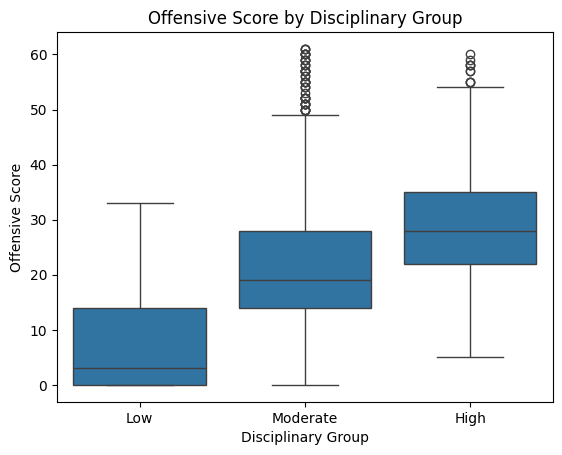

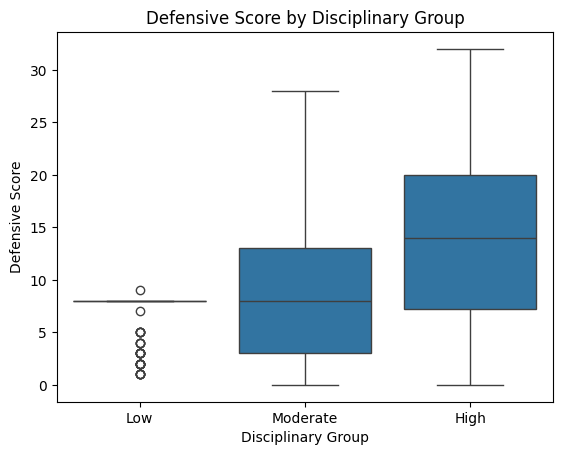

In [573]:
df_explore = pd.DataFrame()
attributes = ['name','total_yellow','total_red','total_goals','total_assists','tackles','interception']
for attribute in attributes:
    df_explore[attribute] = df[attribute]
for index, row in df_explore.iterrows():
    # Calculate scores for the current row
    disciplinary_score = row['total_yellow'] + 2 * row['total_red']
    offensive_score = row['total_goals'] + row['total_assists']
    defensive_score = row['tackles'] + row['interception']
    
    # Assign values to the respective row using the index
    df_explore.at[index, 'disciplinary_score'] = disciplinary_score
    df_explore.at[index, 'offensive_score'] = offensive_score
    df_explore.at[index, 'defensive_score'] = defensive_score

# Label the players group by disciplinary score
mean_score = df_explore['disciplinary_score'].mean()
std_score = df_explore['disciplinary_score'].std()

# Define conditions for grouping
conditions = [
    df_explore['disciplinary_score'] < (mean_score - std_score),  # Low
    (df_explore['disciplinary_score'] >= (mean_score - std_score)) & 
    (df_explore['disciplinary_score'] <= (mean_score + std_score)),  # Moderate
    df_explore['disciplinary_score'] > (mean_score + std_score)  # High
]

# Define group labels
labels = ['Low', 'Moderate', 'High']

# Assign groups to a new column
df_explore['disciplinary_group'] = pd.cut(
    df_explore['disciplinary_score'], 
    bins=[-float('inf'), mean_score - std_score, mean_score + std_score, float('inf')],
    labels=labels
)

# Filter the DataFrame by the 'disciplinary_group'
df_high = df_explore[df_explore['disciplinary_group'] == 'High']
df_moderate = df_explore[df_explore['disciplinary_group'] == 'Moderate']
df_low = df_explore[df_explore['disciplinary_group'] == 'Low']

# Remove Outliers
def remove_outliers(group):
    # Calculate the IQR for offensive_score and defensive_score
    Q1_offensive = group['offensive_score'].quantile(0.25)
    Q3_offensive = group['offensive_score'].quantile(0.75)
    IQR_offensive = Q3_offensive - Q1_offensive
    lower_bound_offensive = Q1_offensive - 1.5 * IQR_offensive
    upper_bound_offensive = Q3_offensive + 1.5 * IQR_offensive
    
    Q1_defensive = group['defensive_score'].quantile(0.25)
    Q3_defensive = group['defensive_score'].quantile(0.75)
    IQR_defensive = Q3_defensive - Q1_defensive
    lower_bound_defensive = Q1_defensive - 1.5 * IQR_defensive
    upper_bound_defensive = Q3_defensive + 1.5 * IQR_defensive
    
    # Filter out the outliers within each group
    filtered_group = group[
        (group['offensive_score'] >= lower_bound_offensive) & 
        (group['offensive_score'] <= upper_bound_offensive) & 
        (group['defensive_score'] >= lower_bound_defensive) & 
        (group['defensive_score'] <= upper_bound_defensive)
    ]
    return filtered_group

df_high = remove_outliers(df_high)
df_moderate = remove_outliers(df_moderate)
df_low = remove_outliers(df_low)

df_explore = pd.concat([df_low,df_moderate,df_high])

# Offensive Score Boxplot (for all groups after outlier removal)
sns.boxplot(x='disciplinary_group', y='offensive_score', data=df_explore)
plt.title('Offensive Score by Disciplinary Group')
plt.xlabel('Disciplinary Group')
plt.ylabel('Offensive Score')
plt.show()

# Defensive Score Boxplot (for all groups after outlier removal)
sns.boxplot(x='disciplinary_group', y='defensive_score', data=df_explore)
plt.title('Defensive Score by Disciplinary Group')
plt.xlabel('Disciplinary Group')
plt.ylabel('Defensive Score')
plt.show()

In [574]:
correlation_offensive = df_explore['disciplinary_score'].corr(df_explore['offensive_score'])
correlation_defensive = df_explore['disciplinary_score'].corr(df_explore['defensive_score'])
# Output results
print(f"Correlation between Disciplinary Score and Offensive Score: {correlation_offensive:.2f}")
print(f"Correlation between Disciplinary Score and Defensive Score: {correlation_defensive:.2f}")

Correlation between Disciplinary Score and Offensive Score: 0.42
Correlation between Disciplinary Score and Defensive Score: 0.37


### Results Interpretation:
- 0.42 for the correlation between disciplinary score and offensive score, which suggests a moderate positive correlation. This means that as the disciplinary score increases, the offensive score tends to increase as well, but the relationship is not perfectly strong.
- 0.37 for the correlation between disciplinary score and defensive score, which indicates a slightly weaker positive correlation, meaning that as the disciplinary score increases, the defensive score also tends to increase, but again, it's a moderate relationship.

In [575]:
# Group offensive_score by disciplinary_group
offensive_groups = [group['offensive_score'].values for name, group in df_explore.groupby('disciplinary_group')]

# Group defensive_score by disciplinary_group
defensive_groups = [group['defensive_score'].values for name, group in df_explore.groupby('disciplinary_group')]

# Offensive Score ANOVA
offensive_anova = stats.f_oneway(*offensive_groups)
print("Offensive Score ANOVA Results:", offensive_anova)

# Defensive Score ANOVA
defensive_anova = stats.f_oneway(*defensive_groups)
print("Defensive Score ANOVA Results:", defensive_anova)

Offensive Score ANOVA Results: F_onewayResult(statistic=143.40023687503486, pvalue=2.8413891930106414e-55)
Defensive Score ANOVA Results: F_onewayResult(statistic=52.857317216765956, pvalue=1.6347775493049362e-22)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19436\266632548.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  offensive_groups = [group['offensive_score'].values for name, group in df_explore.groupby('disciplinary_group')]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19436\266632548.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  defensive_groups = [group['defensive_score'].values for name, group in df_explore.groupby('disciplinary_group')]


### The null hypothesis states that there is no difference between the means of the groups
- A p-value this smaller than your typical significants (ie. 0.05) means the observed differences between the groups are extremely unlikely to have occurred by chance
- We can confidently reject the null hypothesis and conclude that the means of the groups are significantly different.
###  Practical Implication
Disciplinary Score Groups (Low, Moderate, High) have a statistically significant effect on the variable being analyzed (e.g., offensive_score or defensive_score).

In [576]:
# Offensive Score Post-Hoc Test
tukey_offensive = pairwise_tukeyhsd(df_explore['offensive_score'], df_explore['disciplinary_group'])
print("Offensive Score Tukey's HSD Results")
print(tukey_offensive)

# Defensive Score Post-Hoc Test
tukey_defensive = pairwise_tukeyhsd(df_explore['defensive_score'], df_explore['disciplinary_group'])
print("Defensive Score Tukey's HSD Results")
print(tukey_defensive)

Offensive Score Tukey's HSD Results
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj  lower    upper  reject
------------------------------------------------------
  High      Low -23.6359   0.0 -26.9838 -20.288   True
  High Moderate  -7.8251   0.0 -10.3687 -5.2814   True
   Low Moderate  15.8108   0.0  13.0908 18.5308   True
------------------------------------------------------
Defensive Score Tukey's HSD Results
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
  High      Low  -7.1362    0.0 -8.9292 -5.3432   True
  High Moderate  -5.2596    0.0 -6.6219 -3.8973   True
   Low Moderate   1.8766 0.0072  0.4199  3.3334   True
------------------------------------------------------


### Offensive Score Tukey's HSD Results
Key Findings:
1. High vs Low:

- The mean difference is -23.6359 (offensive scores in the High group are significantly lower than in the Low group).
This difference is statistically significant (p-adj = 0.0).

2. High vs Moderate:

- The mean difference is -7.8251 (offensive scores in the High group are lower than in the Moderate group).
This difference is statistically significant (p-adj = 0.0).

3. Low vs Moderate:

- The mean difference is 15.8108 (offensive scores in the Low group are significantly higher than in the Moderate group).
This difference is statistically significant (p-adj = 0.0).

Implications for Offensive Score:
- Players in the Low disciplinary group outperform those in both the Moderate and High groups in terms of offensive performance.
- Players in the High disciplinary group have the poorest offensive performance.
- Increased disciplinary actions may negatively impact offensive contributions.

### Defensive Score Tukey's HSD Results
Key Findings:
1. High vs Low:

- The mean difference is -7.1362 (defensive scores in the High group are significantly lower than in the Low group).
This difference is statistically significant (p-adj = 0.0).

2. High vs Moderate:

- The mean difference is -5.2596 (defensive scores in the High group are lower than in the Moderate group).
This difference is statistically significant (p-adj = 0.0).

3. Low vs Moderate:

- The mean difference is 1.8766 (defensive scores in the Low group are higher than in the Moderate group).
This difference is statistically significant (p-adj = 0.0072).

Implications for Defensive Score:
- Players in the Low disciplinary group outperform those in both the Moderate and High groups in terms of defensive contributions.
- Players in the High disciplinary group also have the lowest defensive performance.
- Higher disciplinary actions may negatively correlate with defensive contributions.


## Contradiction 
### Explaination
- ANOVA & Tukey's HSD focus on comparing group means and show that players in the High disciplinary group perform worse, while players in the Low group perform better. This finding suggests that disciplinary actions (yellow/red cards) might directly negatively affect performance in both offensive and defensive areas.
- Correlation between the disciplinary score and performance scores tells us that there is a moderate positive relationship, but it doesn't distinguish between groups and could be influenced by other factors or outliers that are not captured by the group-based analysis.
### Potiential Reason
- Group-based variance: The groups defined by disciplinary score (Low, Moderate, High) show clear differences, but the overall linear relationship measured by correlation might not fully capture these differences.
- Outliers and distribution: The correlation might be influenced by extreme values or outliers within the data, while the Tukey test specifically focuses on the comparison between groups after removing outliers.
### Conclusion 
- It's important to remember that correlation can show a general trend, but group-based comparisons give more insight into the specific impact of different levels of a variable on performance.
- The correlation results suggest that there is a moderate relationship between disciplinary score and performance, but the group-based analysis reveals that high disciplinary actions have a more pronounced negative effect on performance compared to players with fewer disciplinary actions.\
=> the two methods are providing complementary insights rather than direct contradictions.

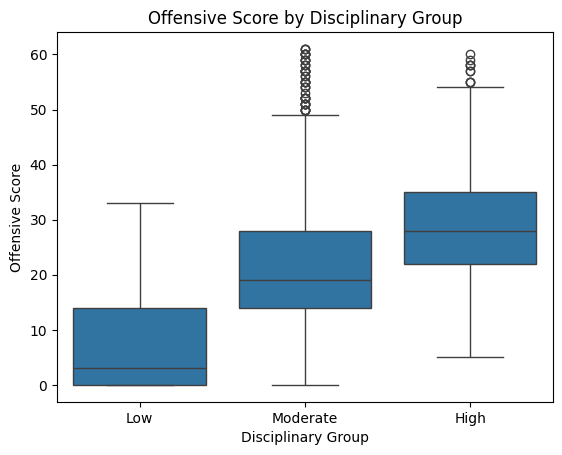

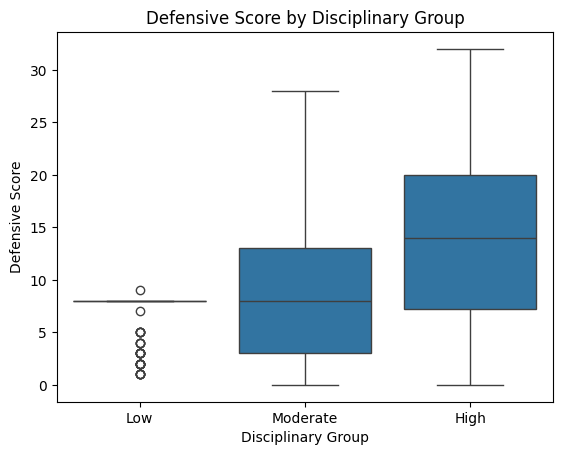

In [577]:
# Offensive Score Boxplot
sns.boxplot(x='disciplinary_group', y='offensive_score', data=df_explore)
plt.title('Offensive Score by Disciplinary Group')
plt.xlabel('Disciplinary Group')
plt.ylabel('Offensive Score')
plt.show()

# Defensive Score Boxplot
sns.boxplot(x='disciplinary_group', y='defensive_score', data=df_explore)
plt.title('Defensive Score by Disciplinary Group')
plt.xlabel('Disciplinary Group')
plt.ylabel('Defensive Score')
plt.show()

## Overall Conclusion
- Offensive and Defensive Performance Declines with Disciplinary Actions:

Players in the High disciplinary group (frequent yellow and red cards) perform poorly both offensively and defensively compared to those in the Low and Moderate groups.
- Low Disciplinary Actions Indicate Better Performance:

Players in the Low disciplinary group show significantly higher offensive and defensive scores.
- Encourage teams to focus on discipline during training to enhance overall player performance.

## Limitation
- The analysis reflects career-long offensive and disciplinary trends but only season-specific defensive contributions.
- More research is required to confidently reach conclusion on players defensive contributions.

## What combination of performance metrics and personal attributes most consistently correlates with a player’s likelihood of winning titles? 
### 